In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.stats import zscore
import math
import os
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import PCA
from sktime.classification.dictionary_based import IndividualTDE
from sklearn import preprocessing
from sklearn.linear_model import orthogonal_mp
from sklearn.linear_model import lasso_path
from sklearn.linear_model import lars_path
from pandasgui import show
import pickle
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import rc
import mvnx

In [3]:
rel_path = 'input_data/AngVel_Data.csv'

rel_novice = 'input_data/EVDSessionLayperson-002.mvnx'

# 'output_data/eigenaction_angvel_fulltest.pickle' for eigenaction dictionary with the length of the dataset as the training data
# 'output_data/eigenaction_angvel_test.pickle' for eigenaction dictionary with 5000 datapoints as the training data

abs_output_path = 'output_data/eigenaction_angvel_95_85_2.pickle'

with open(abs_output_path, "rb") as fp:
    eigen_dict_ang = pickle.load(fp)
print(len(eigen_dict_ang))

30


In [4]:
actions = np.genfromtxt(rel_path, delimiter=',')
actions_check = np.array(actions)
print("This is the shape of the input data: "+ str(actions_check.shape))
data_vel = actions
mean = np.mean(data_vel,axis=0)
data_vel = data_vel - mean

novice_actions = mvnx.load(rel_novice)

This is the shape of the input data: (7363, 69)


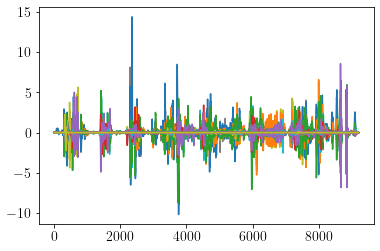

9195


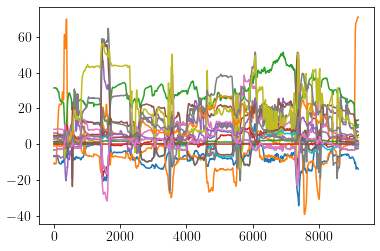

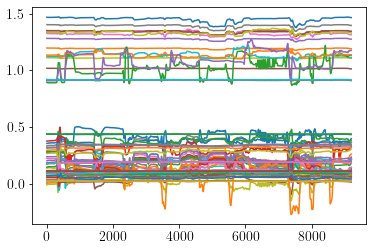

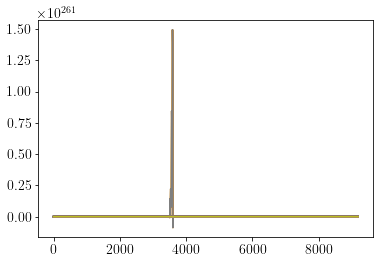

In [23]:
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
novice_ang = novice_actions.angularVelocity
n_mean = np.mean(novice_ang,axis=0)
novice_ang = novice_ang - n_mean
plt.plot(novice_ang)
plt.show()
print(len(novice_ang))

novice_ja = novice_actions.jointAngleErgo
plt.plot(novice_ja)
plt.show()

novice_pos = novice_actions.position
plt.plot(novice_pos)
plt.show()

novice_vel = novice_actions.velocity
plt.plot(novice_vel)
plt.show()

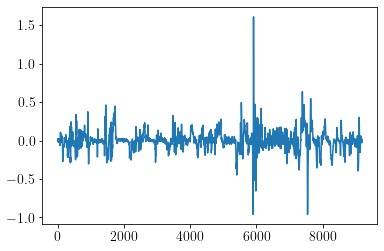

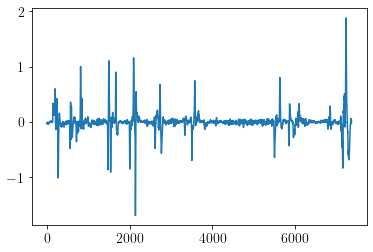

In [37]:
plt.plot(novice_ang[:,19])
plt.show()
plt.plot(data_vel[:,19])
plt.show()

In [6]:
def calculate_reconstruction_score(data,reconstruction):
    score = 1 - np.var(data-reconstruction)/np.var(data)
    return score 

def calculate_reconstruction_error(data, reconstruction):
    error = np.mean(np.sum((reconstruction - data) ** 2) / np.sum(data ** 2))
    return error

In [7]:
def test_eigenmotions(test_data, dictionary): 
    ### Reconstruct
    reconstruction_score_matrix = np.zeros((len(dictionary), len(test_data)))
    idx = 0
    for i in dictionary:
        #(7363, 69) dot (69, 4)
        latent = np.dot(test_data, dictionary[i].T)

        #(7363, 4) dot (4, 69)
        recon = np.dot(latent, dictionary[i])

        reconstruction_scores = 1 - np.var(test_data-recon,axis=1)/np.var(test_data,axis=1)
        reconstruction_score_matrix[idx] = reconstruction_scores
        idx+=1

    greedy_eigenmotion = np.argmax(reconstruction_score_matrix,axis=0)
    best_scores = np.max(reconstruction_score_matrix,axis=0)

    # Best reconstruction
    for i in greedy_eigenmotion:
        latent = np.dot(test_data, list(dictionary.values())[i].T)
        best_reconstruction = np.dot(latent, list(dictionary.values())[i])

    return reconstruction_score_matrix, best_reconstruction, best_scores

In [8]:
for i in eigen_dict_ang:
    print(i)
    print(len(eigen_dict_ang[i]))

eigenmotion_7213
8
eigenmotion_7672
8
eigenmotion_8596
8
eigenmotion_9102
8
eigenmotion_9640
8
eigenmotion_10350
8
eigenmotion_10878
8
eigenmotion_11441
8
eigenmotion_12684
8
eigenmotion_12955
8
eigenmotion_13447
8
eigenmotion_15909
8
eigenmotion_17387
8
eigenmotion_17842
8
eigenmotion_18278
8
eigenmotion_18665
8
eigenmotion_19520
8
eigenmotion_19984
8
eigenmotion_21699
8
eigenmotion_22576
8
eigenmotion_24255
8
eigenmotion_25226
8
eigenmotion_26234
8
eigenmotion_26993
8
eigenmotion_28463
8
eigenmotion_29261
8
eigenmotion_30995
8
eigenmotion_31143
8
eigenmotion_31471
8
eigenmotion_32845
8


In [9]:
def test_eigenmotions_full(test_data, dictionary):
    reconstruction_score_matrix = np.zeros((len(dictionary), len(test_data)))
    reconstructions = np.zeros((len(dictionary), len(test_data), len(data_vel[0,:])))
    best_reconstruction = np.zeros((len(test_data), len(data_vel[0,:])))

    for i in range(len(test_data)):
        idx = 0
        for j in dictionary:
            #(1, 69) dot (69, 8)
            latent = np.dot(test_data[i,:], dictionary[j].T)
            #(1, 8) dot (8, 69)
            recon = np.dot(latent, dictionary[j])
            reconstructions[idx, i, :] = recon
            reconstruction_scores = 1 - np.var(test_data[i,:]-recon)/np.var(test_data[i,:])
            reconstruction_score_matrix[idx,i] = reconstruction_scores
            idx+=1
    
    greedy_eigenmotion = np.argmax(reconstruction_score_matrix,axis=0)

    idx = 0
    for i in greedy_eigenmotion:
        best_reconstruction[idx, :] = reconstructions[i, idx, :]
        idx+=1


    best_scores = np.max(reconstruction_score_matrix,axis=0)

    #     # Best reconstruction
    # for i in greedy_eigenmotion:
    #     latent = np.dot(test_data, list(dictionary.values())[i].T)
    #     best_reconstruction = np.dot(latent, list(dictionary.values())[i])
    
    return reconstruction_score_matrix, best_reconstruction, best_scores, greedy_eigenmotion
            


In [10]:
recon_matrix2, best_recon2, best_score2, eigenmotion_idx = test_eigenmotions_full(data_vel, eigen_dict_ang)

In [11]:
recon_matrixn, best_reconn, best_scoren, eigenmotion_idxn = test_eigenmotions_full(novice_ang, eigen_dict_ang)

In [37]:
recon_matrix1, best_recon1, best_score1, eigenmotion_idx1 = test_eigenmotions_full(data_vel, eigen_dict_ang)

In [113]:
print(np.mean(best_score2))

0.8819300442285173
0.7555468571712396


In [190]:
print(np.mean(best_scoren))

0.7725257688599713


In [69]:
for i in eigen_dict_ang:
    print(eigen_dict_ang[i].shape)

(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)
(8, 69)


0.7584872817345053
(9195,)


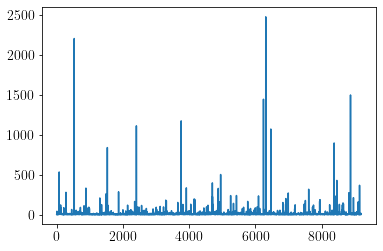

In [145]:
reconstruction_scores = 1 - np.var(novice_ang-best_reconn,axis=1)/np.var(novice_ang,axis=1)
print(np.mean(reconstruction_scores))

#error = np.mean(np.sum((best_reconn - novice_ang) ** 2) / np.sum(novice_ang ** 2), axis=1)
error = np.mean(np.sqrt(((best_reconn - novice_ang) ** 2)/novice_ang ** 2), axis=1)
print(error.shape)
plt.plot(error)
plt.show()

In [32]:
error_matrix = np.zeros((len(novice_ang), 69))
score_matrix = np.zeros(len(novice_ang))
for i in range(len(novice_ang)):
    error = np.sqrt(((best_reconn[i,:] - novice_ang[i,:]) ** 2)/len(novice_ang))
    error_matrix[i, :] = error
    score = 1 - np.var(novice_ang[i,:]-best_reconn[i,:])/np.var(novice_ang[i,:])
    score_matrix[i] = score
    

In [195]:
error_matrix = np.zeros((len(data_vel), 69))
score_matrix = np.zeros(len(data_vel))
for i in range(len(data_vel)):
    error = np.sqrt(((best_recon2[i,:] - data_vel[i,:]) ** 2))
    error_matrix[i, :] = error
    score = 1 - np.var(data_vel[i,:]-best_recon2[i,:])/np.var(data_vel[i,:])
    score_matrix[i] = score

In [13]:
error_vec = np.max(error_matrix, axis=1)
error_bins = np.argmax(error_matrix, axis=1)

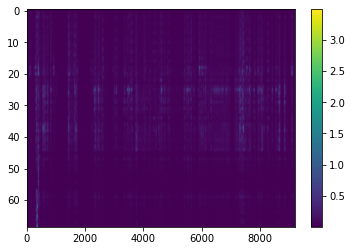

In [18]:
plt.imshow(error_matrix.T, aspect='auto')
plt.colorbar()
plt.show()

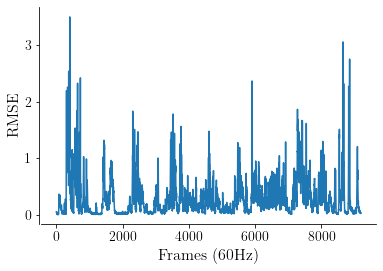

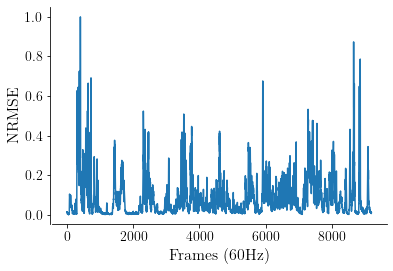

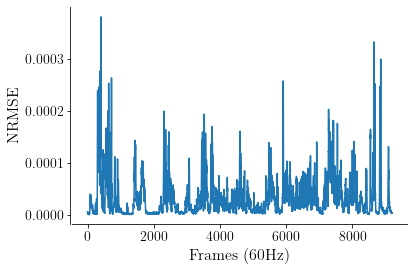

In [33]:
plt.plot(error_vec)
plt.xlabel('Frames (60Hz)', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
sns.despine(offset={'left': 2})
plt.show()

norma = preprocessing.MinMaxScaler(feature_range=(0, 1))
plt.plot(norma.fit_transform(error_vec.reshape(-1,1)))
plt.xlabel('Frames (60Hz)', fontsize=16)
plt.ylabel('NRMSE', fontsize=16)
sns.despine(offset={'left': 2})
plt.show()

plt.plot(error_vec/len(error_vec))
plt.xlabel('Frames (60Hz)', fontsize=16)
plt.ylabel('NRMSE', fontsize=16)
sns.despine(offset={'left': 2})
plt.show()


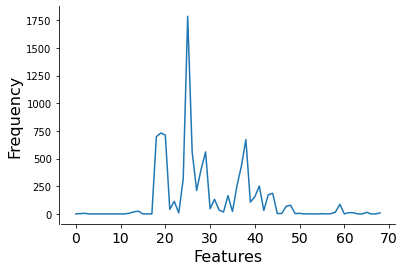

In [15]:
plt.plot(np.bincount(error_bins))
plt.xlabel('Features', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
sns.despine(offset={'left': 2})
xlimz = [0, 10, 20, 30, 40, 50, 60, 70]
plt.xticks(xlimz, fontsize=14)
plt.show()

In [50]:
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

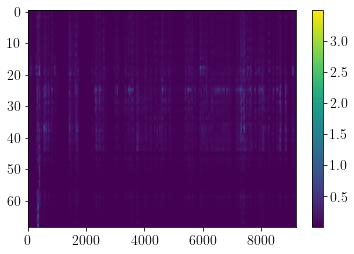

In [147]:
plt.imshow(error_matrix.T, aspect='auto')
plt.colorbar()
plt.show()

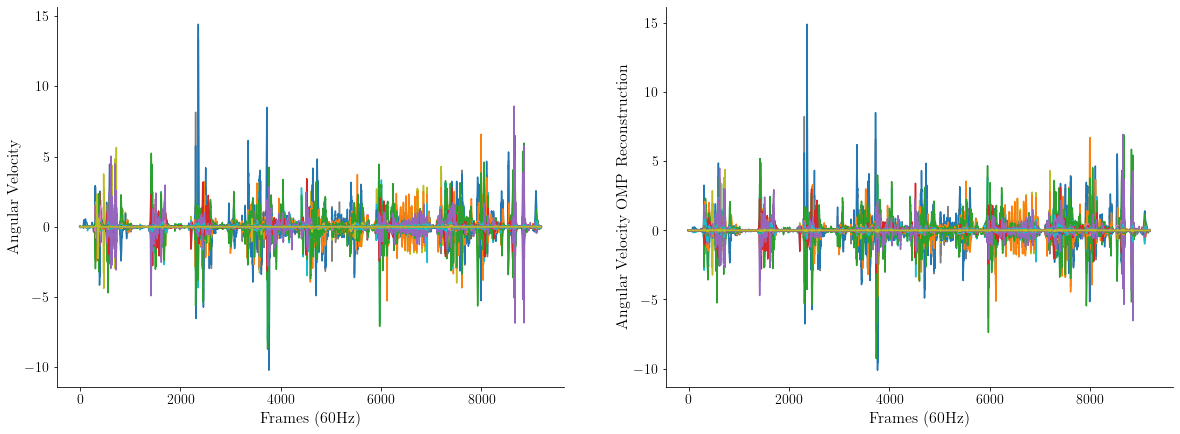

In [24]:
rc('text', usetex=True) 

fig, axs = plt.subplots(1, 2, figsize=(20,7))

axs[0].plot(novice_ang)
axs[0].set_xlabel('Frames (60Hz)', fontsize=16)
axs[0].set_ylabel('Angular Velocity', fontsize=16)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

axs[1].plot(best_reconn)
axs[1].set_xlabel('Frames (60Hz)', fontsize=16)
axs[1].set_ylabel('Angular Velocity OMP Reconstruction', fontsize=16)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

Text(0, 0.5, 'Eigenaction ID')

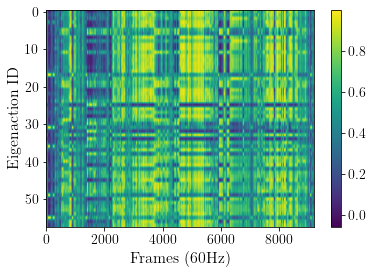

In [124]:
plt.imshow(recon_matrixn, aspect='auto')
plt.colorbar()
plt.xlabel('Frames (60Hz)', fontsize=16)
plt.ylabel('Eigenaction ID', fontsize=16)

In [32]:
#test
recs = np.sort(recon_matrix2, axis=0)
print(np.sort(recon_matrix2[:,0]))
recs = np.flip(recs, axis=0)
print(recs[:,7])

sim_idx = np.where(recs[0,:] - recs[1,:] < 0.05)[0]
print(sim_idx.shape)
print(sim_idx)


[0.18364559 0.1962155  0.21697459 0.22040125 0.2262494  0.24326411
 0.24396529 0.2609048  0.26332518 0.27482902 0.28131595 0.29003259
 0.29347412 0.30101579 0.30349714 0.31951159 0.32071885 0.33209258
 0.33859457 0.34383965 0.34551915 0.34614376 0.3484265  0.354582
 0.36038337 0.36238538 0.36277396 0.36939961 0.37113662 0.37419268
 0.37468127 0.38149133 0.3831704  0.38949131 0.39805703 0.40933616
 0.41102945 0.41188291 0.41208922 0.42222767 0.42561365 0.42682514
 0.44603123 0.44629657 0.44861785 0.44886927 0.45555953 0.46462446
 0.47823765 0.48701777 0.50028711 0.50030234 0.50128006 0.50632826
 0.50673394 0.51178439 0.59041801 0.59574728 0.63222571 0.64469835
 0.66511027 0.74080479]
[0.61985497 0.61356005 0.609131   0.6006546  0.594578   0.59375394
 0.58624886 0.58310551 0.56960023 0.5694294  0.56909557 0.56633104
 0.56415592 0.5618004  0.56001244 0.55569943 0.55022551 0.54896863
 0.54619522 0.54579724 0.5448723  0.54448589 0.5394828  0.53937216
 0.52440033 0.52249654 0.51879402 0.5165

In [54]:
#interference reduction test
low_idx = np.where(best_score2 < np.mean(best_score2)-0.1)[0]
print(len(low_idx))

bestie = best_score2
bestie[low_idx] = 100 

1141


In [43]:
print(len(eigenmotion_idx1))

7363


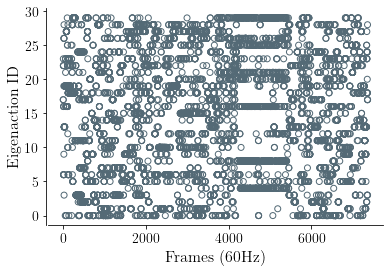

In [130]:
plt.scatter(list(range(0, len(eigenmotion_idx))), eigenmotion_idx, facecolors='none', edgecolors='#546A76')
plt.xlabel('Frames (60Hz)', fontsize=16)
plt.ylabel('Eigenaction ID', fontsize=16)
sns.despine(offset={'left': 2})
plt.show()

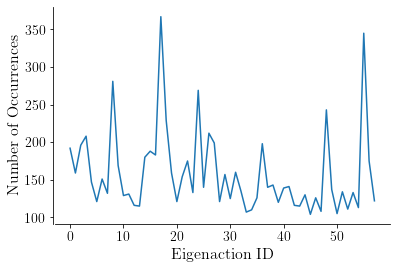

In [125]:
counts = np.bincount(eigenmotion_idxn)
plt.plot(counts)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Eigenaction ID', fontsize=16)
sns.despine(offset={'left': 2})
plt.show()

In [128]:
print(np.argmax(counts))

17


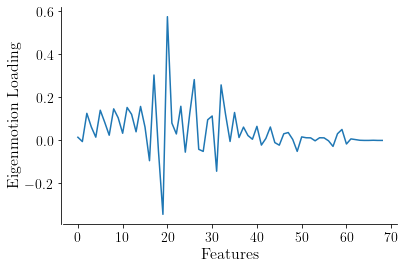

In [79]:
counter = 0
for i in eigen_dict_ang:
    if counter == 5:
        plt.plot(eigen_dict_ang[i][0])
        plt.ylabel('Eigenmotion Loading', fontsize=16)
        plt.xlabel('Features', fontsize=16)
        sns.despine(offset={'left': 2})
        xlimz = [0, 10, 20, 30, 40, 50, 60, 70]
        plt.xticks(xlimz, fontsize=14)
        plt.show()
        break
    else:
        counter = counter + 1

In [102]:
def plot_eigenmotion(eigenmotion):
    eig_sum = np.sum(eigenmotion,axis=0)
    plt.subplots(2, 4, figsize=(20,12))
    for k in range(len(eigenmotion)):
        plt.subplot(2,4,k+1)
        plt.title("Component " + str(k+1))
        plt.bar(np.arange(len(eigenmotion[k])), eigenmotion[k])
        sns.despine(offset={'left': 2})
        plt.xlabel('Features')
        plt.ylabel('Loading')
    plt.show()
    plt.bar(np.arange(len(eig_sum)), eig_sum)
    sns.despine(offset={'left': 2})
    plt.xlabel('Features', fontsize=16)
    plt.ylabel('Loading', fontsize=16)
    xlimz = [0, 10, 20, 30, 40, 50, 60, 70]
    plt.xticks(xlimz, fontsize=14)
    plt.show()

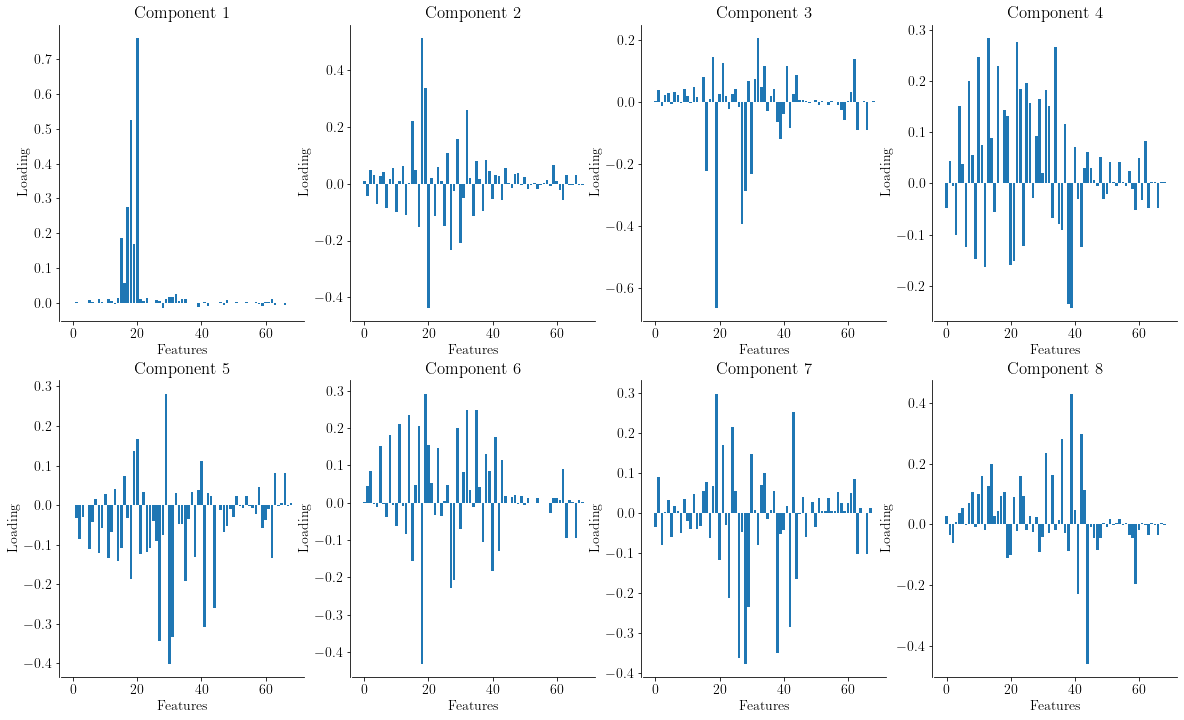

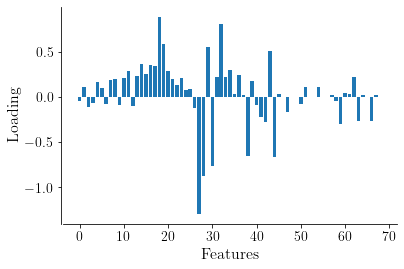

In [129]:
counter = 0
for i in eigen_dict_ang:
    if counter == 17:
        plot_eigenmotion(eigen_dict_ang[i])
        break
    else:
        counter = counter + 1

In [107]:
def moving_average(a, n=7):
    if (n-1)%2 == 0:
        front = np.arange((n-1)/2)
        back = np.arange((n-1)/2)
        
        return np.convolve(a, np.ones(n), 'valid') / n
    else:
        front = np.arange((n-2)/2)
        back = np.arange((n)/2)
    

In [38]:
def moving_averages(a, n=8):
    return np.convolve(a, np.ones(n), 'valid') / n


In [39]:
a = np.arange(20)
mv = moving_averages(a)
print(a)
print(mv)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5]


In [82]:
d = np.ones(len(mv))/mv
print(d)


[0.28571429 0.22222222 0.18181818 0.15384615 0.13333333 0.11764706
 0.10526316 0.0952381  0.08695652 0.08       0.07407407 0.06896552
 0.06451613]


In [79]:
print(len(d[0:3]))

3


In [73]:
print(d.size)

13


In [83]:
ws = 3
for i in range(d.size-ws+1):
    d[i] = np.sum(d[i:(i+ws)])/ws
for i in range(d.size-ws+1, d.size-1):
    d[i] = np.sum(d[i:-1])/len(d[i:-1])
print(d)

[0.22991823 0.18596219 0.15633256 0.13494218 0.11874785 0.10604944
 0.09581926 0.08739821 0.08034353 0.07434653 0.06918524 0.06896552
 0.06451613]


In [34]:
dim1 = 5
dim2 = 4
objp = np.zeros((dim2*dim1,3), np.float32)
objp[:,:2] = np.mgrid[0:dim1,0:dim2].T.reshape(-1,2)
#objp = objp*24